In [1]:
import urllib.request
import calplot
import json
import requests
import pandas as pd
from collections import namedtuple
from datetime import datetime, timedelta
import time
import matplotlib.pyplot as plt

In [2]:
api_endpoint = "http://history.openweathermap.org/data/2.5/history/city"

city="pune"
start = "1588320000"
end = "1618387200"
timespan = "1259231&type=hour&start="
num = 1588320000

apikey = "48128adf2151a7b0d01be89c19424ff2"


features = [ "date","temp", "temp_min", "temp_max", "feels_like", "pressure", "humidity"]
DailySummary = namedtuple("DailySummary", features)


In [3]:
def extract_weather_data():
    records=[]
    num = 1588320000
    start = "1588320000"
    for i in range(1588320000, 1618387200, 86400):
        url = api_endpoint + "?id=" + timespan + start + "&end=" + start + "&appid=" + apikey + "&units=metric"
        request = url
        response = requests.get(request)
        if response.status_code == 200:
            date = int(response.json()["list"][0]["dt"])
            local_time = datetime.fromtimestamp(date)
            data_date = local_time.strftime("%d-%m-%Y")
            data_temp = response.json()["list"][0]["main"]["temp"]
            data_temp_min = response.json()["list"][0]["main"]["temp_min"]
            data_temp_max = response.json()["list"][0]["main"]["temp_max"]
            data_feels_like = response.json()["list"][0]["main"]["feels_like"]
            data_pressure = response.json()["list"][0]["main"]["pressure"]
            data_humidity = response.json()["list"][0]["main"]["humidity"]
            records.append(DailySummary(
                data_date,
                data_temp,
                data_temp_min,
                data_temp_max,
                data_feels_like,
                data_pressure,
                data_humidity))

        num = num + 86400
        start = str(num)
    return records


In [4]:
records = extract_weather_data()
#print(records)

In [5]:
print("City: " + city.upper())

City: PUNE


In [6]:
df = pd.DataFrame(records, columns=features).set_index('date')

In [7]:
tmp = df[['temp', 'temp_min', 'temp_max']].head(10)
tmp

,temp,temp_min,temp_max
date,,,
01-05-2020,313.54,313.54,313.54
02-05-2020,312.80,312.80,312.80
03-05-2020,313.37,313.37,313.37
04-05-2020,310.07,310.07,310.07
05-05-2020,308.49,308.49,308.49
06-05-2020,311.97,311.97,311.97
07-05-2020,309.17,309.17,309.17
08-05-2020,311.64,311.64,311.64
09-05-2020,313.93,313.93,313.93


In [8]:
# 1 day prior
N = 1

# target measurement of temperature
feature = 'temp'

# total number of rows
rows = tmp.shape[0]

# a list representing Nth prior measurements of feature
# notice that the front of the list needs to be padded with N
# None values to maintain the constistent rows length for each N
nth_prior_measurements = [None]*N + [tmp[feature][i-N] for i in range(N, rows)]

# make a new column name of feature_N and add to DataFrame
col_name = "{}_{}".format(feature, N)
tmp[col_name] = nth_prior_measurements
tmp

,temp,temp_min,temp_max,temp_1
date,,,,
01-05-2020,313.54,313.54,313.54,NaN
02-05-2020,312.80,312.80,312.80,313.54
03-05-2020,313.37,313.37,313.37,312.80
04-05-2020,310.07,310.07,310.07,313.37
05-05-2020,308.49,308.49,308.49,310.07
06-05-2020,311.97,311.97,311.97,308.49
07-05-2020,309.17,309.17,309.17,311.97
08-05-2020,311.64,311.64,311.64,309.17
09-05-2020,313.93,313.93,313.93,311.64


In [9]:
def derive_nth_day_feature(df, feature, N):
    rows = df.shape[0]
    nth_prior_measurements = [None]*N + [df[feature][i-N] for i in range(N, rows)]
    col_name = "{}_{}".format(feature, N)
    df[col_name] = nth_prior_measurements

In [10]:
 for feature in features:
     if feature != 'date':
        for N in range(1, 4):
            derive_nth_day_feature(df, feature, N)

In [11]:
print(df.columns)

Index(['temp', 'temp_min', 'temp_max', 'feels_like', 'pressure', 'humidity',
       'temp_1', 'temp_2', 'temp_3', 'temp_min_1', 'temp_min_2', 'temp_min_3',
       'temp_max_1', 'temp_max_2', 'temp_max_3', 'feels_like_1',
       'feels_like_2', 'feels_like_3', 'pressure_1', 'pressure_2',
       'pressure_3', 'humidity_1', 'humidity_2', 'humidity_3'],
      dtype='object')


In [12]:
to_remove = [feature 
             for feature in features 
             if feature not in ['temp', 'temp_min', 'temp_max']]

# make a list of columns to keep
to_keep = [col for col in df.columns if col not in to_remove]

# select only the columns in to_keep and assign to df
df = df[to_keep]
df.columns

Index(['temp', 'temp_min', 'temp_max', 'temp_1', 'temp_2', 'temp_3',
       'temp_min_1', 'temp_min_2', 'temp_min_3', 'temp_max_1', 'temp_max_2',
       'temp_max_3', 'feels_like_1', 'feels_like_2', 'feels_like_3',
       'pressure_1', 'pressure_2', 'pressure_3', 'humidity_1', 'humidity_2',
       'humidity_3'],
      dtype='object')

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 348 entries, 01-05-2020 to 13-04-2021
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   temp          348 non-null    float64
 1   temp_min      348 non-null    float64
 2   temp_max      348 non-null    float64
 3   temp_1        347 non-null    float64
 4   temp_2        346 non-null    float64
 5   temp_3        345 non-null    float64
 6   temp_min_1    347 non-null    float64
 7   temp_min_2    346 non-null    float64
 8   temp_min_3    345 non-null    float64
 9   temp_max_1    347 non-null    float64
 10  temp_max_2    346 non-null    float64
 11  temp_max_3    345 non-null    float64
 12  feels_like_1  347 non-null    float64
 13  feels_like_2  346 non-null    float64
 14  feels_like_3  345 non-null    float64
 15  pressure_1    347 non-null    float64
 16  pressure_2    346 non-null    float64
 17  pressure_3    345 non-null    float64
 18  humidity_1    347 n

In [14]:
df = df.apply(pd.to_numeric, errors='coerce')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 348 entries, 01-05-2020 to 13-04-2021
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   temp          348 non-null    float64
 1   temp_min      348 non-null    float64
 2   temp_max      348 non-null    float64
 3   temp_1        347 non-null    float64
 4   temp_2        346 non-null    float64
 5   temp_3        345 non-null    float64
 6   temp_min_1    347 non-null    float64
 7   temp_min_2    346 non-null    float64
 8   temp_min_3    345 non-null    float64
 9   temp_max_1    347 non-null    float64
 10  temp_max_2    346 non-null    float64
 11  temp_max_3    345 non-null    float64
 12  feels_like_1  347 non-null    float64
 13  feels_like_2  346 non-null    float64
 14  feels_like_3  345 non-null    float64
 15  pressure_1    347 non-null    float64
 16  pressure_2    346 non-null    float64
 17  pressure_3    345 non-null    float64
 18  humidity_1    347 n

In [15]:
# Call describe on df and transpose it due to the large number of columns
spread = df.describe().T

# precalculate interquartile range for ease of use in next calculation
IQR = spread['75%'] - spread['25%']

# create an outliers column which is either 3 IQRs below the first quartile or
# 3 IQRs above the third quartile
spread['outliers'] = (spread['min']<(spread['25%']-(3*IQR)))|(spread['max'] > (spread['75%']+3*IQR))
# just display the features containing extreme outliers
spread.loc[spread.outliers,]
spread

,count,mean,std,min,25%,50%,75%,max,outliers
temp,348.0,305.825891,7.361092,288.94,299.7375,307.680,310.6900,319.63,False
temp_min,348.0,305.825891,7.361092,288.94,299.7375,307.680,310.6900,319.63,False
temp_max,348.0,305.825891,7.361092,288.94,299.7375,307.680,310.6900,319.63,False
temp_1,347.0,305.805965,7.362318,288.94,299.7350,307.670,310.6700,319.63,False
temp_2,346.0,305.787746,7.365142,288.94,299.7325,307.615,310.6225,319.63,False
temp_3,345.0,305.770000,7.368428,288.94,299.7300,307.560,310.4800,319.63,False
temp_min_1,347.0,305.805965,7.362318,288.94,299.7350,307.670,310.6700,319.63,False
temp_min_2,346.0,305.787746,7.365142,288.94,299.7325,307.615,310.6225,319.63,False
temp_min_3,345.0,305.770000,7.368428,288.94,299.7300,307.560,310.4800,319.63,False
temp_max_1,347.0,305.805965,7.362318,288.94,299.7350,307.670,310.6700,319.63,False


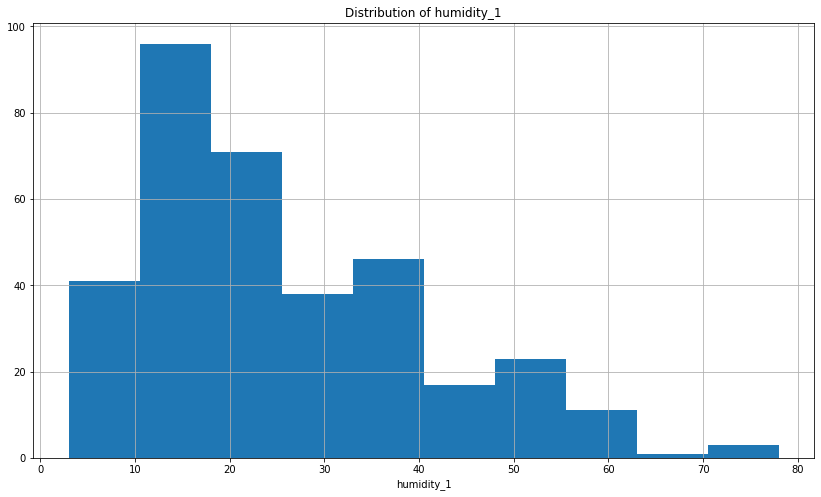

In [16]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [14, 8]
df.humidity_1.hist()
plt.title('Distribution of humidity_1')
plt.xlabel('humidity_1')
plt.show()

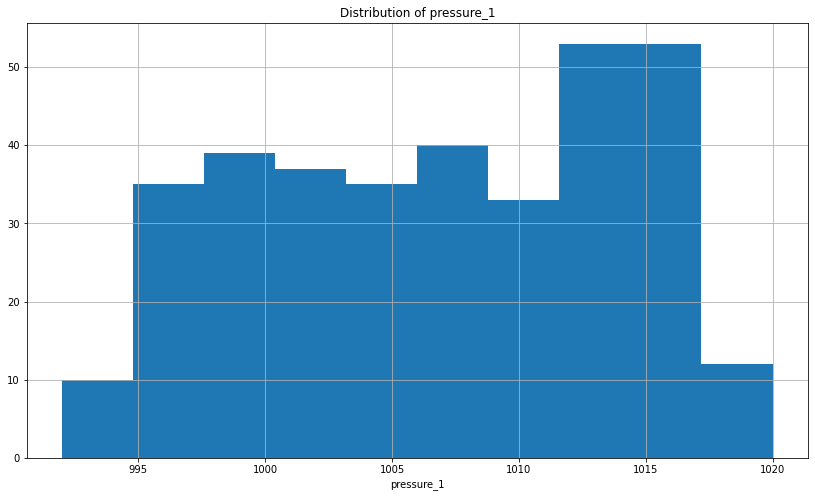

In [17]:
df.pressure_1.hist()
plt.title('Distribution of pressure_1')
plt.xlabel('pressure_1')
plt.show()

In [18]:
# iterate over the precip columns
for feels_like_col in ['feels_like_1', 'feels_like_2', 'feels_like_3']:
    # create a boolean array of values representing nans
    missing_vals = pd.isnull(df[feels_like_col])
    df[feels_like_col][missing_vals] = 0

In [19]:
df = df.dropna()

In [20]:
load = pd.read_csv("Ex__Data\ex_data.csv")

In [21]:
load.head()

,temp,temp_min,temp_max,temp_1,temp_2,temp_3,temp_min_1,temp_min_2,temp_min_3,temp_max_1,...,feels_like_1,feels_like_2,feels_like_3,pressure_1,pressure_2,pressure_3,humidity_1,humidity_2,humidity_3,date
0,310.07,310.07,310.07,313.37,312.80,313.54,313.37,312.80,313.54,313.37,...,310.54,309.76,309.59,1004,1003,1005,15,18,13,01-05-2020
1,308.49,308.49,308.49,310.07,313.37,312.80,310.07,313.37,312.80,310.07,...,309.23,310.54,309.76,1007,1004,1003,22,15,18,02-05-2020
2,311.97,311.97,311.97,308.49,310.07,313.37,308.49,310.07,313.37,308.49,...,306.56,309.23,310.54,1007,1007,1004,21,22,15,03-05-2020
3,309.17,309.17,309.17,311.97,308.49,310.07,311.97,308.49,310.07,311.97,...,309.93,306.56,309.23,1004,1007,1007,13,21,22,04-05-2020
4,311.64,311.64,311.64,309.17,311.97,308.49,309.17,311.97,308.49,309.17,...,308.47,309.93,306.56,1007,1004,1007,18,13,21,05-05-2020


In [22]:
df.to_excel(r'C:\\Users\\AYUSH\\OneDrive\\Desktop\\Project\\ex_data.xlsx', sheet_name='ex_data', index = False)